In [1]:
import numpy as np
import scipy.integrate as integrate
from scipy.special import legendre
from scipy.integrate import simpson
import matplotlib.pyplot as plt


In [2]:
class AtTemp:
    """
    Represents a system at a specific temperature with properties relevant to eigenvalue calculations.
    
    Attributes:
        a (float): Parameter 'a' affecting the system's behavior.
        N (int): The number of points or elements considered in the system.
        omega_0 (float): A fundamental frequency of the system.
        matsubara (int): The number of Matsubara frequencies to consider.
        ng2 (float): A parameter related to the system's interaction strength.
        T (float): The temperature of the system.
    """

    def __init__(self, a, N, omega_0, matsubara, ng2, T):
        """
        Initializes the AtTemp instance with specified parameters and calculates initial properties.
        """
        self.a = a
        self.N = N
        self.omega_0 = omega_0
        self.matsubara = matsubara
        self.ng2 = ng2
        self.T = T
        self.omega = self.omega_matsu()
        self.lambda_iso = self.val_lambda()
        self.theta = self.theta_array()
        self.zz = self.Z()
        self.integration = self.phi_integration_simpson()
        self.matrix = self.cal_matrix()
        self.eigenvalues = self.eigenvalue_prob()
        self.largest_eigenvalue = self.max_eigenvalue()

    def omega_matsu(self):
        """
        Calculates the Matsubara frequencies for the system.
        
        Returns:
            np.ndarray: Array of Matsubara frequencies.
        """
        omega = np.asarray([(2 * (-(self.matsubara/2) + i) + 1) * np.pi * self.T for i in range(self.matsubara)]) # matsubara frequencies
        return omega
    
    def val_lambda(self):
        lambda_iso = np.asarray(
            [
                [
                    2
                    * self.omega_0
                    * self.ng2
                    / (np.square(self.omega[i] - self.omega[j]) + np.square(self.omega_0))
                    for j in range(len(self.omega))
                ]
                for i in range(len(self.omega))
            ]
        )
        return lambda_iso
    
    def theta_array(self):
        theta = np.linspace(0, np.pi, self.matsubara)
        return theta
    
    def Z(self):
        X = (self.omega / np.abs(self.omega)) * self.lambda_iso
        zz = 1 + (self.T/(8*self.omega)) * (1 + self.a* (legendre(self.N)(np.cos(self.theta))) ) *  4*np.pi * np.sum(X, axis=1)
        return zz
    
    def phi_integration_simpson(self):
        denominator = self.zz
        numerator = (1 + self.a * (legendre(self.N)(np.cos(self.theta))) )**2
        sub_integrand = np.divide(numerator, denominator)
        integrand = np.sin(self.theta) * 2*np.pi * sub_integrand
        integration = integrate.simpson(integrand, self.theta)
        return integration
    
    def cal_matrix(self):
        k_matrix = self.T/8 * self.lambda_iso * self.integration 
        matrix = np.divide(k_matrix, np.abs(self.omega))
        return matrix
    
    def eigenvalue_prob(self):
        eigenvalues, _ = np.linalg.eig(self.matrix)
        return eigenvalues
    
    def max_eigenvalue(self):
        return np.max(self.eigenvalues)
    
    def t_iter_update(self, T_new):
        self.T = T_new
        self.omega = self.omega_matsu()
        self.lambda_iso = self.val_lambda()
        self.zz = self.Z()
        self.integration = self.phi_integration_simpson()
        self.matrix = self.cal_matrix()
        self.eigenvalues = self.eigenvalue_prob()
        updated_eigenvalue = self.max_eigenvalue()
        return updated_eigenvalue

In [3]:
class ForAvalue(AtTemp):
    """
    Extends AtTemp to iteratively calculate and evaluate eigenvalues over a range of temperatures 
    until a specified eigenvalue limit is exceeded.
    
    Attributes:
        eignevalue_limit (float): The target eigenvalue limit for iteration.
        T_start (float): The starting temperature for the iteration.
        T_steps (float): The temperature increment for each iteration step.
    """
    def __init__(self, a, N, omega_0, matsubara, ng2, eignevalue_limit, T_start, T_steps):
        """
        Initializes the ForAvalue instance with specific system parameters and iteration settings.
        """
        super().__init__(a, N, omega_0, matsubara, ng2, T_start) # initialize the parent class
        self.eignevalue_limit = eignevalue_limit
        self.T_start = T_start
        self.T_steps = T_steps
        self.T_values, self.eigenvalues_forT = self.iter_over_t()

    def iter_over_t(self):
        """
        Iterates over temperatures, updating the system's state and calculating eigenvalues 
        until the largest eigenvalue exceeds the specified limit.
        
        Returns:
            tuple: A tuple containing two lists, the first of temperature values and the second of corresponding largest eigenvalues.
        """
        eigenvalues_forT = []
        T_values = []
        T = self.T_start
        eigenvalues_forT.append(self.largest_eigenvalue)
        T_values.append(T)
        if self.largest_eigenvalue > self.eignevalue_limit:
            while self.largest_eigenvalue > self.eignevalue_limit:
                T += self.T_steps
                self.largest_eigenvalue = self.t_iter_update(T_new=T)
                eigenvalues_forT.append(self.largest_eigenvalue)
                T_values.append(T)
        else:
                print("The eigenvalue is already smaller than 1")

        return T_values, eigenvalues_forT # please note, self.eigevalues has already been used in the parent class so you might want to change this name

In [4]:
class ExploreEigenvalue:
    def __init__(self, a_values, N, omega_0, matsubara, ng2, eignevalue_limit, T_start, T_steps):
        self.a_values = a_values
        self.N = N
        self.omega_0 = omega_0
        self.matsubara = matsubara
        self.ng2 = ng2
        self.eignevalue_limit = eignevalue_limit
        self.T_start = T_start
        self.T_steps = T_steps
        self.data = self.iter_over_a()
        
    def iter_over_a(self):
        parent_dict = {}
        for a in self.a_values:
            a_value_data = ForAvalue(a, self.N, self.omega_0, self.matsubara, self.ng2, self.eignevalue_limit, self.T_start, self.T_steps)
            nested_dict = {}
            nested_dict['T_values'] = a_value_data.T_values
            nested_dict['eigenvalues'] = a_value_data.eigenvalues_forT
            parent_dict[a] = nested_dict
            
        return parent_dict
            
        

In [5]:
omega_0 = 0.05 # phonon frequency
ng2 = 0.0144 # coupling strength?

#T = 0.00014
matsubara = 200
a = [-0.3, -0.2, -0.1, -0.05, -0.01, 0.0, 0.01, 0.05, 0.1, 0.2, 0.3]
N = 2

eignevalue_limit = 0.9
T_start = 0.00014
T_steps = 0.00001

In [6]:
lessdo = ExploreEigenvalue(a, N, omega_0, matsubara, ng2, eignevalue_limit, T_start, T_steps)

In [7]:
parent_dict = lessdo.data

/home/pawanprakash/miniconda3/envs/anisotel/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


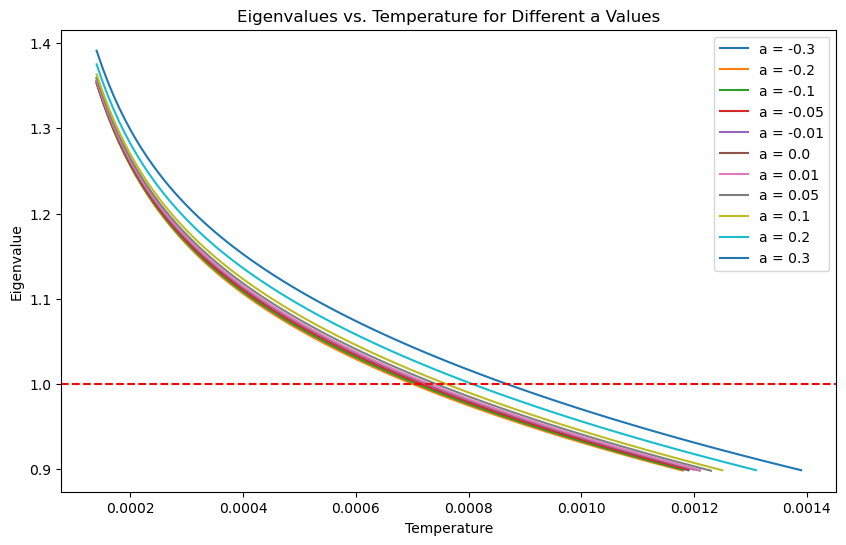

In [8]:
# Set up the plot
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size

for a, data in parent_dict.items():
    # Extract T_values and eigenvalues from the nested dictionary
    T_values = data['T_values']
    eigenvalues = data['eigenvalues']
    
    # Plot each line with label for the value of 'a'
    plt.plot(T_values, eigenvalues, label=f'a = {a}')

# Adding labels and title for clarity
plt.xlabel('Temperature')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues vs. Temperature for Different a Values')
plt.axhline(y=1.0, color='r', linestyle='--')

# Adding a legend to distinguish different 'a' values
plt.legend()

# Show the plot
plt.show()


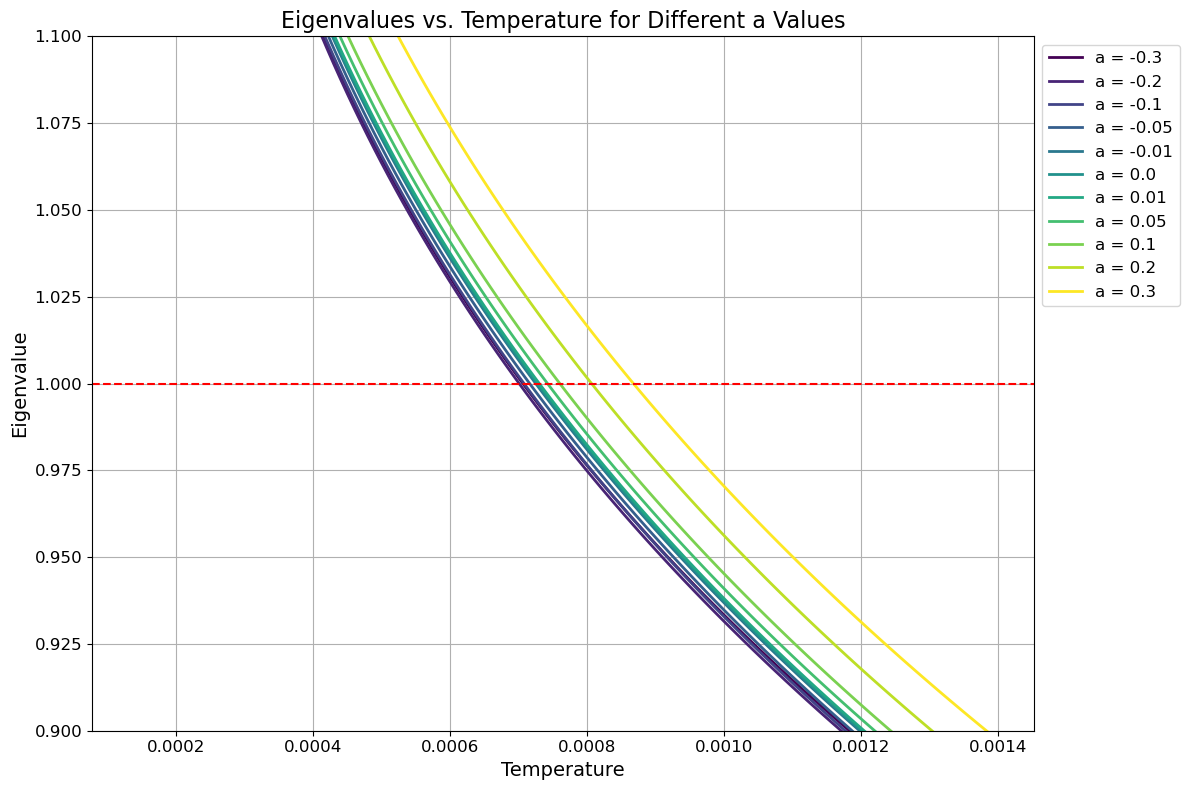

In [9]:
# Set up the plot with a larger figure size
plt.figure(figsize=(12, 8))

# Generate a color map or a list of distinct colors
colors = plt.cm.viridis(np.linspace(0, 1, len(parent_dict)))

# Plot each line with a unique color and label
for (a, data), color in zip(parent_dict.items(), colors):
    plt.plot(data['T_values'], data['eigenvalues'], label=f'a = {a}', linewidth=2, color=color)

# Adding labels with larger font size for clarity
plt.xlabel('Temperature', fontsize=14)
plt.ylabel('Eigenvalue', fontsize=14)

# Adding a title with a larger font size
plt.title('Eigenvalues vs. Temperature for Different a Values', fontsize=16)

# Adding a grid for better readability
plt.grid(True)

# Increasing tick label size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.axhline(y=1.0, color='r', linestyle='--')

# Adding a legend outside the plot area to prevent it from covering the data
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

# Optionally, set a limit for the Y-axis to zoom in on areas of interest
plt.ylim([0.9, 1.1])

# Show the plot with adjustments
plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()


In [10]:
smallest_temp = 0.00014  # The smallest temperature you're interested in

for a, data in parent_dict.items():
    # Assuming 'T_values' is sorted, find the index of the smallest temperature
    try:
        index_of_smallest_temp = data['T_values'].index(smallest_temp)
    except ValueError:
        # If the smallest temp is not in the list, handle it appropriately (skip or print a message)
        print(f"Smallest temperature {smallest_temp} not found for 'a' = {a}")
        continue

    # Use the index to find the corresponding eigenvalue
    eigenvalue_at_smallest_temp = data['eigenvalues'][index_of_smallest_temp]

    # Print the 'a' value and the corresponding eigenvalue
    print(f"'a' = {a}: Eigenvalue at T = {smallest_temp} is {eigenvalue_at_smallest_temp}")


'a' = -0.3: Eigenvalue at T = 0.00014 is (1.3586641572003098+0j)
'a' = -0.2: Eigenvalue at T = 0.00014 is (1.3534213747287778+0j)
'a' = -0.1: Eigenvalue at T = 0.00014 is (1.3524788850729494+0j)
'a' = -0.05: Eigenvalue at T = 0.00014 is (1.353609661025141+0j)
'a' = -0.01: Eigenvalue at T = 0.00014 is (1.35527961658729+0j)
'a' = 0.0: Eigenvalue at T = 0.00014 is (1.3558031476527395+0j)
'a' = 0.01: Eigenvalue at T = 0.00014 is (1.356369036049058+0j)
'a' = 0.05: Eigenvalue at T = 0.00014 is (1.3590555811402876+0j)
'a' = 0.1: Eigenvalue at T = 0.00014 is (1.3633633675351133+0j)
'a' = 0.2: Eigenvalue at T = 0.00014 is (1.3751314681873288+0j)
'a' = 0.3: Eigenvalue at T = 0.00014 is (1.3910820689976824+0j)


In [12]:
# Assuming parent_dict is structured as before
smallest_temp = 0.00014  # The smallest temperature you're interested in

# Create a list of (a, eigenvalue) tuples for the smallest temperature
a_eigenvalue_pairs = []
for a, data in parent_dict.items():
    try:
        # Assuming 'T_values' are sorted
        index_of_smallest_temp = data['T_values'].index(smallest_temp)
        eigenvalue_at_smallest_temp = data['eigenvalues'][index_of_smallest_temp]
        a_eigenvalue_pairs.append((a, eigenvalue_at_smallest_temp))
    except ValueError:
        # Handle the case where the smallest temperature is not in the list for this 'a'
        continue

# Sort the list of tuples based on the eigenvalues in ascending order
sorted_a_eigenvalues = sorted(a_eigenvalue_pairs, key=lambda pair: pair[1])

# Print the sorted eigenvalues and the corresponding 'a' values
for a, eigenvalue in sorted_a_eigenvalues:
    print(f"'a' = {a}: Eigenvalue at T = {smallest_temp} is {eigenvalue}")


'a' = -0.1: Eigenvalue at T = 0.00014 is (1.3524788850729494+0j)
'a' = -0.2: Eigenvalue at T = 0.00014 is (1.3534213747287778+0j)
'a' = -0.05: Eigenvalue at T = 0.00014 is (1.353609661025141+0j)
'a' = -0.01: Eigenvalue at T = 0.00014 is (1.35527961658729+0j)
'a' = 0.0: Eigenvalue at T = 0.00014 is (1.3558031476527395+0j)
'a' = 0.01: Eigenvalue at T = 0.00014 is (1.356369036049058+0j)
'a' = -0.3: Eigenvalue at T = 0.00014 is (1.3586641572003098+0j)
'a' = 0.05: Eigenvalue at T = 0.00014 is (1.3590555811402876+0j)
'a' = 0.1: Eigenvalue at T = 0.00014 is (1.3633633675351133+0j)
'a' = 0.2: Eigenvalue at T = 0.00014 is (1.3751314681873288+0j)
'a' = 0.3: Eigenvalue at T = 0.00014 is (1.3910820689976824+0j)
